# Ejercicio 1

In [4]:
import pandas as pd

class NaiveBayesClassifier:

    def train(self, df, alpha=1):
        grouped_classes = df.groupby('Nacionalidad')
        self.classes = df['Nacionalidad'].unique()
        self.attributes = df.columns[0: -1]
        self.class_probabilities = {}
        self.attribute_probabilities = {}
        total_len = len(df)

        for _class, grouped in grouped_classes:
            data_len = len(grouped)
            self.class_probabilities[_class] = data_len/ total_len
            self.attribute_probabilities[_class] = {}
            for attribute in df.columns[0:-1]:    # Skipping last column (Nacionalidad)
                self.attribute_probabilities[_class][attribute] = (grouped[attribute].sum() + alpha) / (data_len + alpha * len(self.classes))
    
    def print_probabilities(self, values):
        prediction = {}
        for _class in self.classes:
            probability = self.class_probabilities[_class]
            for i,value in enumerate(values):
                if value == 1:
                    probability *= self.attribute_probabilities[_class][self.attributes[i]]
                else: 
                    probability *= 1 - self.attribute_probabilities[_class][self.attributes[i]] # 1 - P(A) = P(not A)
            prediction[_class] = probability
        for _class, value in prediction.items():
            print(_class, value / sum(prediction.values()))  # divide the probability by the sum of all probabilities to get the normalized probability


file = 'inputs/PreferenciasBritanicos.xlsx'
brits_df = pd.read_excel(file)
classifier = NaiveBayesClassifier()
classifier.train(brits_df)
# 1.B
classifier.print_probabilities([1, 0, 1, 1, 1])
print()
# 1.C
classifier.print_probabilities([0, 1, 1, 0, 1])

I 0.27857725833819524
E 0.7214227416618048

I 0.8317268190077327
E 0.1682731809922672


# Ejercicio 2

## Paso 1: preprocesamiento del dataset
Primero necesitamos hacer un preprocesamiento de los datos. Para esto decidimos reducir el dataset a 4 categorías, preferencialmente que no guarden demasiada correlación entre ellas en cuanto a las palabras utilizadas y asegurarnos que el modelo logre diferenciarlas correctamente sin tener que lidiar con las otras categorías. Una vez que el objetivo sea cumplido agregaremos devuelta las categorías filtradas para utilizar el dataset completo.

Para el preprocesamiento de los titulos utilizaremos tecnicas utilizadas en NLP y las aplicaremos a los titulos, procedemos a la tokenización de las palabras en los titulos,  

In [18]:
import re
import nltk 
#nltk.download("stopwords")
#nltk.download("snowball_data")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

class NewsClassifier:

    def __init__(self, use_stopwords, use_stemmer):
        self.train_df = None
        self.test_df = None
        self.vocabulary = set()
        self.vocabulary_size = None
        self.word_occurencies_per_class = {}
        self.total_tokens_per_class = defaultdict(int)
        self.class_frequency_map = None
        self.labels = None
        self.confusion_matrix = None
        self.use_stopwords = use_stopwords
        self.use_stemmer = use_stemmer

    def preprocess_text_spanish(self,text, use_stopwords, use_stemmer):
        # Convert to lowercase and remove punctuation
        text = re.sub(r'[^\w\s]', '', text.lower())
    
        # Tokenization
        tokens = text.split()
        if use_stopwords:
            # Remove stop words
            stop_words = set(stopwords.words("spanish"))
            tokens = [token for token in tokens if token not in stop_words]
    
        if use_stemmer:
            # Stemming (use SnowballStemmer for Spanish)
            stemmer = SnowballStemmer("spanish")
            tokens = [stemmer.stem(token) for token in tokens]
        return tokens

    def split_dataset(self, test_percentage, dataset_path, categories):
        file = dataset_path
        news_df = pd.read_excel(file)
        accepted_cats = categories
        filtered_df = news_df[news_df['categoria'].isin(accepted_cats)]
        
        if test_percentage != 0:
            self.train_df, self.test_df = train_test_split(filtered_df, test_size=test_percentage/100, random_state=42)
            self.labels = self.train_df['categoria']
        else:
            self.train_df = filtered_df
            self.labels = filtered_df['categoria']

    def train(self, alpha=1):
        matrix_per_category = {}
        # Apply CountVectorizer to the titles per category
        for label in self.labels.unique():
            category_df = self.train_df[self.train_df['categoria'] == label]
            preprocessed_titles = [self.preprocess_text_spanish(title, self.use_stopwords, self.use_stemmer) for title in category_df["titular"]]
            self.vocabulary = set(self.vocabulary).union(set([token for tokens in preprocessed_titles for token in tokens]))
            preprocessed_titles_strings = [" ".join(tokens) for tokens in preprocessed_titles]
            vectorizer = CountVectorizer()
            X = vectorizer.fit_transform(preprocessed_titles_strings)
            count_matrix = X.toarray()
            df = pd.DataFrame(count_matrix, columns=vectorizer.get_feature_names_out())
            matrix_per_category[label] = df


        self.vocabulary_size = len(self.vocabulary)
        self.class_frequency_map = {}

        for label in self.labels.unique():
            self.class_frequency_map[label] = (self.train_df['categoria'] == label).sum() / self.train_df.shape[0]

        # Count word occurrences in each class
        for label in self.labels.unique():
            self.word_occurencies_per_class[label] = defaultdict(int)
            for word in matrix_per_category[label].columns:
                self.word_occurencies_per_class[label][word] = matrix_per_category[label][word].sum() 
            self.total_tokens_per_class[label] = matrix_per_category[label].sum().sum()     

        self.conditional_probabilities = {}
        # Calculate conditional probabilities for each word in each class
        for label in self.labels.unique():
            self.conditional_probabilities[label] = {}
            for word in self.vocabulary:
                self.conditional_probabilities[label][word] = (self.word_occurencies_per_class[label][word] + alpha) / (self.total_tokens_per_class[label] + alpha * len(self.labels.unique()))
            
                
    def predict_title(self, new_title):
        # Preprocess the new title
        new_title_tokens = self.preprocess_text_spanish(new_title, self.use_stopwords, self.use_stemmer)

        # Calculate probabilities for each class
        predicted_probabilities = {}
        for class_label, class_frequency in self.class_frequency_map.items():
            prob_word_given_class = class_frequency  # P(cat|token) = P(cat) * P(token|cat) = P(cat) * P(token1|cat) * P(token2|cat) * ... * P(tokenN|cat) 
            for token in new_title_tokens:
                if token in self.vocabulary:
                    prob_word_given_class *= self.conditional_probabilities[class_label][token]
            predicted_probabilities[class_label] = prob_word_given_class

        # Divide by the sum of all probabilities to get the normalized probability
        total_probability = sum(predicted_probabilities.values())
        for class_label in predicted_probabilities.keys():
            predicted_probabilities[class_label] = predicted_probabilities[class_label] / total_probability
        # Return the class with the highest probability
        return max(predicted_probabilities, key=predicted_probabilities.get), predicted_probabilities
       


    def calculate_confusion_matrix_ROC(self,label, umbral):
        roc_matrix = {}
        roc_matrix[label] = {}
        roc_matrix['other'] = {}
        roc_matrix[label][label] =0
        roc_matrix[label]['other'] =0
        roc_matrix['other'][label] =0
        roc_matrix['other']['other'] =0
        for index, row in self.test_df.iterrows():
            expected_result = row['categoria']
            predicted_result, predicted_probabilities = self.predict_title(row['titular'])
            if expected_result == predicted_result:
                if expected_result == label:
                    if predicted_probabilities[predicted_result] >= umbral:
                        roc_matrix[label][label] += 1
                    else:
                        roc_matrix[label]['other'] += 1
                else:
                   roc_matrix['other']['other'] += 1 
            else:
                if expected_result == label:
                    roc_matrix[label]['other'] += 1
                else:
                    roc_matrix['other'][label] += 1
        return roc_matrix
    
    
    def calculate_confusion_matrix(self):
        self.confusion_matrix = {}
        for label in self.class_frequency_map.keys():
            self.confusion_matrix[label] = {}
            for column_label in self.class_frequency_map.keys():
                self.confusion_matrix[label][column_label] = 0
        for index, row in self.test_df.iterrows():
            expected_result = row['categoria']
            predicted_result,_ = self.predict_title(row['titular'])
            self.confusion_matrix[expected_result][predicted_result] += 1
        return self.confusion_matrix
    
    def change_confusion_matrix_to_freq(self):
        label_ocurrences = {}
        label_ocurrences[label] = (self.test_df['categoria'] == label).sum()
        for row in self.confusion_matrix.keys():
            for column in self.confusion_matrix[row].keys():
                self.confusion_matrix[row][column] /= label_ocurrences[row]
                
    def print_confusion_matrix(self, matrix):
        for row in matrix.keys():
            for column in matrix[row].keys():
                print(row, column, matrix[row][column])
            
    def calculate_accuracy(self, matrix):
        asserted = 0
        total = 0
        for row in matrix.keys():
            for column in matrix.keys():
                if row == column:
                    asserted += matrix[row][column]
                total += matrix[row][column]
        return asserted / total
        
    def calculate_true_positives(self, category, matrix):
        false_negatives = matrix[category]['other']
        true_positives = matrix[category][category]          
        return true_positives/(true_positives + false_negatives)
        
    def calculate_precision(self, category, matrix):
        true_positives = matrix[category][category]
        false_positives = matrix['other'][category]           
        return true_positives/(true_positives + false_positives)
        
    def calculate_false_positives(self, category, matrix):
        true_negatives = matrix['other']['other']
        false_positives = matrix['other'][category]
        return false_positives / (false_positives + true_negatives)
        
    def calculate_f1_score(self,category, matrix):
        precision = self.calculate_precision(category, matrix)
        recall = self.calculate_true_positives(category, matrix)
        return (2*precision*recall)/(precision+recall)



In [8]:
file = 'inputs/NoticiasArgentinas.xlsx'
categories = ['Nacional', "Destacadas", "Entretenimiento", "Salud", "Deportes"]
classifier = NewsClassifier(True, True)
classifier.split_dataset(40, file, categories) # 40% test, 60% train
classifier.train()

category = 'Nacional'

roc_matrix = classifier.calculate_confusion_matrix_ROC(category, 0.4)

print("accuracy: ",classifier.calculate_accuracy(roc_matrix))
print("true_positives: ",classifier.calculate_true_positives(category,roc_matrix))
print("precision: ",classifier.calculate_precision(category, roc_matrix))
print("f1-score: ",classifier.calculate_f1_score(category, roc_matrix))
print("false_positives: ",classifier.calculate_false_positives(category, roc_matrix))

accuracy:  0.8300025953802233
true_positives:  0.7388451443569554
precision:  0.5525024533856723
f1-score:  0.6322290847838293
false_positives:  0.1475250727919767


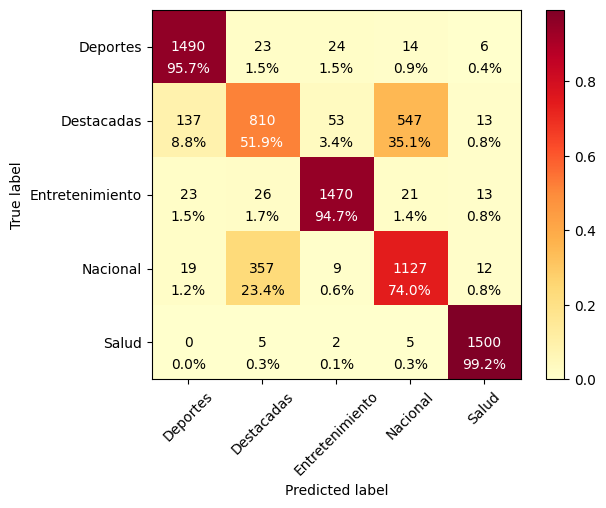

In [10]:
conf_mtx = classifier.calculate_confusion_matrix()

def plot_confusion_matrix(matrix):
    # Convert the dictionary to a matrix
    labels = sorted(matrix.keys())
    matrix = np.array([[matrix[true_label][pred_label] for pred_label in labels] for true_label in labels])

    # Normalize the confusion matrix
    matrix_norm = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix as an image
    plt.imshow(matrix_norm, interpolation='nearest', cmap="YlOrRd")

    # Add a colorbar to the plot
    plt.colorbar()

    # Add labels to the plot
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Add values to the cells of the plot
    for i, j in np.ndindex(matrix.shape):
        count = matrix[i, j]
        percent = matrix_norm[i, j] * 100
        plt.text(j, i, f"{count:.0f}",
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if matrix_norm[i, j] > 0.5 else "black")
        plt.text(j, i+0.3, f"{percent:.1f}%",
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if matrix_norm[i, j] > 0.5 else "black")

    # Show the plot
    plt.show()

plot_confusion_matrix(conf_mtx)

In [19]:
import matplotlib.pyplot as plt
import numpy as np

class Tester:
    
    def __init__(self, use_stopwords, use_stemmer, dataset):
        self.classifier = NewsClassifier(use_stopwords, use_stemmer)
        self.dataset = dataset

    def plot_roc(self, test_percentage, categories):
        self.classifier.split_dataset(test_percentage, self.dataset, categories)
        self.classifier.train()
        TVP_map = {} 
        TFP_map = {}
        for category in categories:
            TVP_map[category] = []
            TFP_map[category] = []
        for category in categories:
            for i in np.arange(0, 1, 0.001):
                roc_matrix = self.classifier.calculate_confusion_matrix_ROC(category, i)
                TVP_map[category].append(self.classifier.calculate_true_positives(category, roc_matrix))
                TFP_map[category].append(self.classifier.calculate_false_positives(category, roc_matrix))
          
        plt.figure()
        for category in categories:
            plt.plot(TFP_map[category],TVP_map[category], label=category)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc='lower right')
        plt.show()
    
    def plot_parameters(self, test_percentage, categories):
        metrics = ['Accuracy', 'Precision', 'TVP', 'TFP', 'F1-score']
        plot_map = {}
        self.classifier.split_dataset(test_percentage, self.dataset, categories)
        self.classifier.train()
        for metric in metrics:
            plot_map[metric] = []
            for category in categories:
                roc_matrix = self.classifier.calculate_confusion_matrix_ROC(category, 0.8)
                if metric == 'Accuracy':
                    plot_map[metric].append(round(self.classifier.calculate_accuracy(roc_matrix),1))
                elif metric == 'Precision':
                    plot_map[metric].append(round(self.classifier.calculate_precision(category, roc_matrix),1))
                elif metric == 'TVP':
                    plot_map[metric].append(round(self.classifier.calculate_true_positives(category, roc_matrix),1))
                elif metric == 'TFP':
                    plot_map[metric].append(round(self.classifier.calculate_false_positives(category, roc_matrix),3))
                elif metric == 'F1-score':
                    plot_map[metric].append(round(self.classifier.calculate_f1_score(category, roc_matrix),2))
        
        species = categories

        x = np.arange(len(species))  # the label locations
        width = 0.2  # the width of the bars
        multiplier = 0

        fig, ax = plt.subplots(layout='constrained')
        
        for attribute, measurement in plot_map.items():
            offset = width * multiplier
            rects = ax.bar(x + offset, measurement, width, label=attribute)
            ax.bar_label(rects, padding=5)
            multiplier += 1

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_title('Metricas por clase')
        ax.set_xticks(x + width, species)
        ax.legend(loc='upper left', ncols=5)
        ax.set_ylim(0, 1.8)

        plt.show()

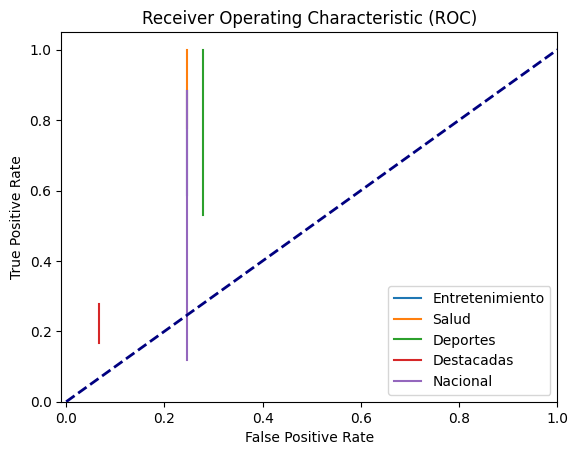

In [20]:
file = 'inputs/NoticiasArgentinas.xlsx'
categories = ["Entretenimiento", "Salud", "Deportes", "Destacadas", "Nacional"]
tester = Tester(True,True,file)
tester.plot_roc(0.4, categories)

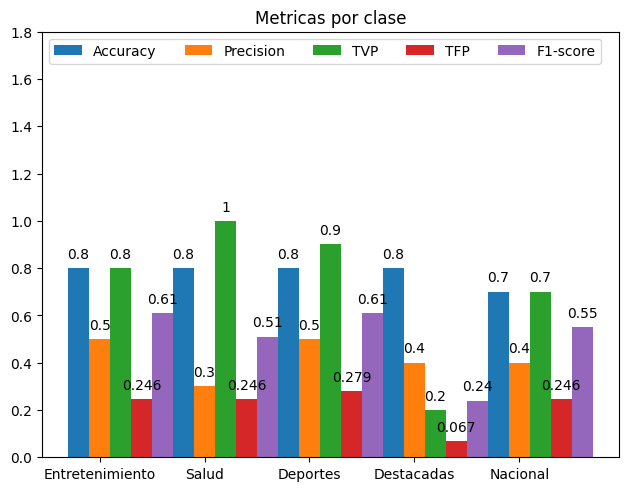

In [16]:
file = 'inputs/NoticiasArgentinas.xlsx'
categories = ["Entretenimiento", "Salud", "Deportes", "Destacadas", "Nacional"]
tester = Tester(True,True,file)
tester.plot_parameters(0.4, categories)

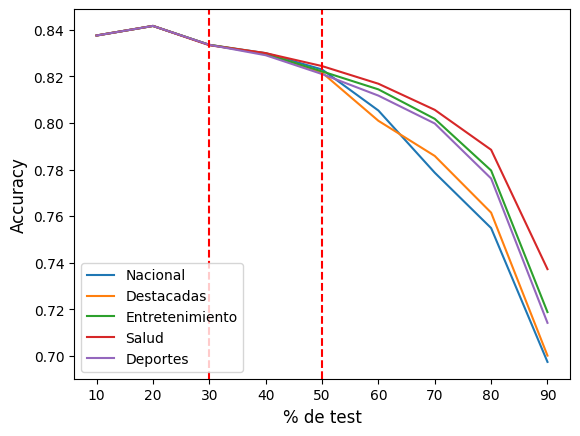

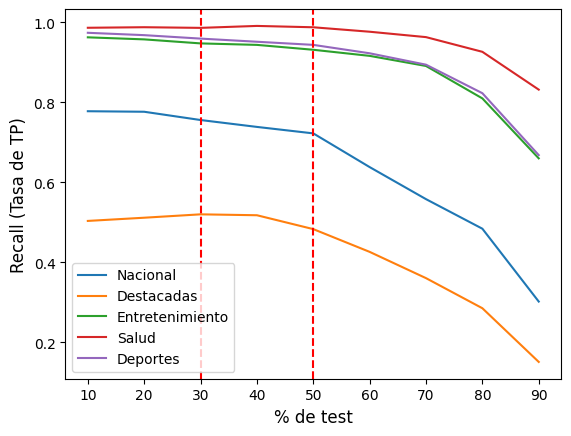

In [32]:
import matplotlib.pyplot as plt
import numpy as np

#file = 'inputs/NoticiasArgentinas.xlsx'
categories = ['Nacional', "Destacadas", "Entretenimiento", "Salud", "Deportes"]
percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90]
#category_accuracies = {}
#category_recall = {}

#for percentage in percentages:
#    classifier = NewsClassifier(True, True)
#    classifier.split_dataset(percentage, file, categories) # 40% test, 60% train
#    classifier.train()
#    for category in categories:
#        if category not in category_accuracies:
#            category_accuracies[category] = []
#        if category not in category_recall:
#            category_recall[category] = []
#        roc_matrix = classifier.calculate_confusion_matrix_ROC(category, percentage / 100)
#        category_accuracies[category].append(classifier.calculate_accuracy(roc_matrix))
#        category_recall[category].append(classifier.calculate_true_positives(category, roc_matrix))

#print(percentages)
#print(category_accuracies)
#print(category_recall)

category_accuracies = {
    'Nacional': [0.8375713544369486, 0.8416818063846353, 0.8335640138408305, 0.8300025953802233, 0.822985880398671, 0.8053464832597975, 0.778642936596218, 0.7548663379185051, 0.6973699388626139],
    'Destacadas': [0.8375713544369486, 0.8416818063846353, 0.8335640138408305, 0.8298728263690631, 0.8216362126245847, 0.800934336880353, 0.785836114200964, 0.761484557487672, 0.7000807474910601],
    'Entretenimiento': [0.8375713544369486, 0.8416818063846353, 0.8335640138408305, 0.8296132883467427, 0.822155315614618, 0.814430314041007, 0.8017797552836485, 0.7795873345445108, 0.7187680239935402],
    'Salud': [0.8375713544369486, 0.8416818063846353, 0.8333910034602076, 0.8300025953802233, 0.8244393687707641, 0.8168526689159962, 0.8056358917315536, 0.78847651180898, 0.7372245933787057],
    'Deportes': [0.8375713544369486, 0.8416818063846353, 0.8335640138408305, 0.8290942123021022, 0.8210132890365448, 0.8117484211436976, 0.7997775305895439, 0.7761484557487672, 0.7141538816472488]
}

category_recall = {
    'Nacional': [0.7780678851174935, 0.7767503302509907, 0.7560763888888888, 0.7388451443569554, 0.722662440570523, 0.6383715894326548, 0.5582000743770918, 0.4842583576760792, 0.3020713463751438],
    'Destacadas': [0.5037406483790524, 0.5117493472584856, 0.5202063628546861, 0.517948717948718, 0.48323878287777206, 0.42634315424610053, 0.3606437454279444, 0.2853925353925354, 0.15112262521588946],
    'Entretenimiento': [0.9628647214854111, 0.9577464788732394, 0.9476793248945148, 0.943979394719897, 0.9317476732161324, 0.9165224913494809, 0.8912149532710281, 0.8101430429128739, 0.6602416570771001],
    'Salud': [0.9867724867724867, 0.9881578947368421, 0.9865350089766607, 0.9914021164021164, 0.9880145909327774, 0.9768861753161797, 0.9633918565558461, 0.9266535690897184, 0.8320787492762015],
    'Deportes': [0.9742268041237113, 0.9683143219264893, 0.9596912521440824, 0.9518304431599229, 0.9440164355418593, 0.9229781771501926, 0.8944649446494465, 0.8231490462334303, 0.6683053788316946]
}

for category, values in category_accuracies.items():
    plt.plot(percentages, values, label=category)
plt.legend()
plt.axvline(x = 30, color = 'r', linestyle='dashed')
plt.axvline(x = 50, color = 'r', linestyle='dashed')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('% de test', fontsize=12)
plt.show()

for category, values in category_recall.items():
    plt.plot(percentages, values, label=category)
plt.legend()
plt.axvline(x = 30, color = 'r', linestyle='dashed')
plt.axvline(x = 50, color = 'r', linestyle='dashed')
plt.ylabel('Recall (Tasa de TP)', fontsize=12)
plt.xlabel('% de test', fontsize=12)
plt.show()

In [112]:
import pandas as pd

def discretize_variable(variable, umbral):
    return 1 if variable >= umbral else 0

def discretize_gre(gre, umbral = 500):
    return discretize_variable(gre, umbral)

def discretize_gpa(gpa, umbral = 3):
    return discretize_variable(gpa, umbral)

file = 'inputs/binary.csv'
students_df = pd.read_csv(file)
student_amount = len(students_df)

ranks = [1, 2, 3, 4]
admits = [0, 1]

# Creating auxiliar matrices to use
rank_df = pd.DataFrame(columns=['rank1_True', 'rank2_True', 'rank3_True', 'rank4_True'])
rank_df.loc[0] = [0, 0, 0, 0]

gre_probs = []
for rank in ranks:
    gre_probs.append([rank, 0, 0])
gre_df = pd.DataFrame(data=gre_probs, columns=['rank', 'gre_True', 'gre_False'])

gpa_probs = []
for rank in ranks:
    gpa_probs.append([rank, 0, 0])
gpa_df = pd.DataFrame(data=gpa_probs, columns=['rank', 'gpa_True', 'gpa_False'])

admit_probs = []
for rank in ranks:
    for gre in [0, 1]:
        for gpa in [0, 1]:
            admit_probs.append([rank, gre, gpa, 0, 0])
admit_df = pd.DataFrame(data=admit_probs, columns=['rank', 'gre', 'gpa', 'admit_True', 'admit_False'])

# Loading data
for student_id in students_df.index:
    rank_idx = students_df['rank'][student_id] - 1
    rank_df.loc[0][rank_idx] += 1

for student_id in students_df.index:
    gre = discretize_gre(students_df['gre'][student_id])
    gpa = discretize_gpa(students_df['gpa'][student_id])
    rank = students_df['rank'][student_id]
    gre_df.loc[gre_df['rank'] == rank , 'gre_True' if gre == 1 else 'gre_False'] += 1
    gpa_df.loc[gpa_df['rank'] == rank , 'gpa_True' if gpa == 1 else 'gpa_False'] += 1

for student_id in students_df.index:
    gpa = discretize_gpa(students_df['gpa'][student_id])
    gre = discretize_gre(students_df['gre'][student_id])
    rank = students_df['rank'][student_id]
    admit = students_df['admit'][student_id]
    admit_df.loc[(admit_df['rank'] == rank) & (admit_df['gre'] == gre) & (admit_df['gpa'] == gpa), 'admit_True' if admit == 1 else 'admit_False'] += 1

# print(rank_df)
# print(gre_df)
# print(gpa_df)
# print(admit_df)

rank_probs = []
for column in rank_df:
    rank_probs.append((rank_df[column].loc[0] + 1) / (sum(rank_df.iloc[0]) + len(rank_df.columns)))
rank_df.iloc[0] = rank_probs
print(rank_df)
print()

for i in gre_df.index:
    probs = []
    probs.append((gre_df['gre_True'][i] + 1) / (gre_df['gre_True'][i] + gre_df['gre_False'][i] + 2))
    probs.append((gre_df['gre_False'][i] + 1) / (gre_df['gre_True'][i] + gre_df['gre_False'][i] + 2))
    gre_df.at[i, 'gre_True'] = probs[0]
    gre_df.at[i, 'gre_False'] = probs[1]
print(gre_df)
print()

for i in gpa_df.index:
    probs = []
    probs.append((gpa_df['gpa_True'][i] + 1) / (gpa_df['gpa_True'][i] + gpa_df['gpa_False'][i] + 2))
    probs.append((gpa_df['gpa_False'][i] + 1) / (gpa_df['gpa_True'][i] + gpa_df['gpa_False'][i] + 2))
    gpa_df.at[i, 'gpa_True'] = probs[0]
    gpa_df.at[i, 'gpa_False'] = probs[1]
print(gpa_df)
print()

for i in admit_df.index:
    probs = []
    probs.append((admit_df['admit_True'][i] + 1) / (admit_df['admit_True'][i] + admit_df['admit_False'][i] + 2))
    probs.append((admit_df['admit_False'][i] + 1) / (admit_df['admit_True'][i] + admit_df['admit_False'][i] + 2))
    admit_df.at[i, 'admit_True'] = probs[0]
    admit_df.at[i, 'admit_False'] = probs[1]
print(admit_df)
print()

# 3.a -> P(!admitido | rango=1) = P(!admitido ^ rango=1) / P(rango=1)
# P(!admitido ^ rango=1) = Sum_GPE(0,1){Sum_GPA(0,1){P(!admitido ^ GPE ^ GPA ^ rango=1}} = P(!admitido ^ !gpe ^ !gpa ^ rango = 1) * ... * P(!admitido ^ gpe ^ gpa ^ rango = 1)
# Ej: P(!admitido ^ !gpe ^ !gpa ^ rango=1) = P(!admitido | !gpe ^ !gpa ^ rango=1) * P(!gpe | rango=1) * P(!gpa | rango=1) * P(rango=1)
# p1: P(!admitido | !gpe ^ !gpa ^ rango=1)
# p2: P(!gpe | rango=1)
# p3: P(!gpa | rango=1)
probability_3a = 0

for gre in [0, 1]:
    for gpa in [0, 1]:
        p1 = float(admit_df.loc[(admit_df['gre'] == gre) & (admit_df['gpa'] == gpa) & (admit_df['rank'] == 1), 'admit_False'].iloc[0])
        p2 = float(gre_df.loc[gre_df['rank'] == 1, 'gre_True' if gre == 1 else 'gre_False'].iloc[0])
        p3 = float(gpa_df.loc[gpa_df['rank'] == 1, 'gpa_True' if gpa == 1 else 'gpa_False'].iloc[0])

        # print(p1)
        # print(p2)
        # print(p3)
        # print()

        probability_3a += p1 * p2 * p3

print('Ejercicio 3a:', probability_3a)

# 3.b -> P(admitido | r=2 ^ !gre ^ gpa) = P(admitido ^ r=2 ^ !gre ^ gpa) / Sum_ADMIT(0,1){P(r=2 ^ !gre ^ gpa ^ ADMIT)}
# P(admitido ^ r=2 ^ !gre ^ gpa) = P(admitido | !gpe ^ gpa ^ r=2) * P(!gpe | r=2) * P(gpa | r=2) * P(r=2)
# P(!admitido ^ r=2 ^ !gre ^ gpa) = P(!admitido | !gpe ^ gpa ^ r=2) * P(!gpe | r=2) * P(gpa | r=2) * P(r=2)
# Entonces: P(admitido | r=2 ^ !gre ^ gpa) = P(admitido ^ !gpe ^ gpa ^ r=2) / (P(admitido ^ !gpe ^ gpa ^ r=2) + P(!admitido ^ !gpe ^ gpa ^ r=2))
probabilities_3b = []
for admit in [0, 1]:
    p1 = float(admit_df.loc[(admit_df['gre'] == 0) & (admit_df['gpa'] == 1) & (admit_df['rank'] == 2), 'admit_True' if admit == 1 else 'admit_False'].iloc[0])
    p2 = float(gre_df.loc[gre_df['rank'] == 2, 'gre_False'].iloc[0])
    p3 = float(gpa_df.loc[gpa_df['rank'] == 2, 'gpa_True'].iloc[0])

    # print(p1)
    # print(p2)
    # print(p3)
    # print()

    probabilities_3b.append(p1 * p2 * p3)

print('Ejercicio 3b:', probabilities_3b[1] / sum(probabilities_3b))

   rank1_True  rank2_True  rank3_True  rank4_True
0    0.153465    0.376238     0.30198    0.168317

   rank  gre_True  gre_False
0     1  0.809524   0.190476
1     2  0.810458   0.189542
2     3  0.788618   0.211382
3     4  0.782609   0.217391

   rank  gpa_True  gpa_False
0     1  0.857143   0.142857
1     2  0.823529   0.176471
2     3  0.829268   0.170732
3     4  0.797101   0.202899

    rank  gre  gpa  admit_True  admit_False
0      1    0    0    0.285714     0.714286
1      1    0    1    0.500000     0.500000
2      1    1    0    0.800000     0.200000
3      1    1    1    0.551020     0.448980
4      2    0    0    0.444444     0.555556
5      2    0    1    0.217391     0.782609
6      2    1    0    0.190476     0.809524
7      2    1    1    0.424528     0.575472
8      3    0    0    0.090909     0.909091
9      3    0    1    0.222222     0.777778
10     3    1    0    0.384615     0.615385
11     3    1    1    0.252874     0.747126
12     4    0    0    0.166667     